In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
import scipy.stats as spstat
import time

from conquer.linear_model import high_dim

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

The reference machine used for the simulations below is an iMac with a 3.7 GHz 6-Core Intel i5 processor and 32 GB of RAM. Each simulation exploits only one processor, without any parallelism.

### Bootstrap model selection and post-selection inference for high-dimensional quantile regression

In [2]:
n = 256
p = 1028
s = 8
tau = 0.8
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
beta = np.zeros(p)
beta[:21] = [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, -1, 0, 0, -1]
true_set = np.where(beta!=0)[0]
print('true model:', true_set+1)

true model: [ 1  3  6  9 12 15 18 21]


In [3]:
ci_cover, ci_width = np.zeros([3, p]), np.zeros([3, p])
M = 200
# true and false positives
tp, fp = np.zeros(M), np.zeros(M)
mb_tp, mb_fp = np.zeros(M), np.zeros(M)

runtime = 0
for m in range(M):
    rgt.seed(m)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = 4 + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    hd_sqr = high_dim(X, Y, intercept=True)
    lambda_sim = 0.75*np.quantile(hd_sqr.self_tuning(tau), 0.9)

    tic = time.time()  
    boot_model = hd_sqr.boot_inference(Lambda=lambda_sim, tau=tau, \
                                       weight="Multinomial")
    runtime += time.time() - tic
    
    mb_ci = boot_model['boot_ci']
    est_set = np.where(boot_model['boot_beta'][1:,0]!=0)[0]
    mb_set = boot_model['majority_vote']
    tp[m] =  len(np.intersect1d(true_set, est_set))
    fp[m] = len(np.setdiff1d(est_set, true_set))
    mb_tp[m] = len(np.intersect1d(true_set, mb_set))
    mb_fp[m] = len(np.setdiff1d(mb_set, true_set))
    
    for c in range(3):
        ci_cover[c,:] += 1*(beta >= mb_ci[c,1:,0])*(beta<= mb_ci[c,1:,1])
        ci_width[c,:] += mb_ci[c,1:,1] - mb_ci[c,1:,0]
        
    if (m+1)%10 == 0: print(m+1,'repetitions')

10 repetitions
20 repetitions
30 repetitions
40 repetitions
50 repetitions
60 repetitions
70 repetitions
80 repetitions
90 repetitions
100 repetitions
110 repetitions
120 repetitions
130 repetitions
140 repetitions
150 repetitions
160 repetitions
170 repetitions
180 repetitions
190 repetitions
200 repetitions


In [4]:
ave_cover, ave_width = ci_cover/M, ci_width/M
cover = pd.DataFrame(np.concatenate([ave_cover.T, beta[:,None]], axis=1), columns=['percentile', 'pivotal', 'normal','true beta'])
width = pd.DataFrame(np.concatenate([ave_width.T, beta[:,None]], axis=1), columns=['percentile', 'pivotal', 'normal','true beta'])

boot_out = pd.concat([width.iloc[true_set,:3], cover.iloc[true_set,:3]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out,
      '\ntrue model:',      true_set+1,
      '\naverage runtime:', runtime/M,
      '\ntrue positive:',   np.mean(tp), 
      '\nfalse positive:',  np.mean(fp),
      '\nVSC prob:',        np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:',  np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nVSC prob after boot:',  np.mean((mb_tp==8)*(mb_fp==0)))
# VSC: variable selection consistency

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.335565  0.335565  0.339435       0.950    0.895   0.960
3     0.456708  0.456708  0.463897       0.985    0.930   0.965
6     0.349404  0.349404  0.353550       0.965    0.925   0.950
9     0.445086  0.445086  0.454860       0.965    0.960   0.975
12    0.412100  0.412100  0.421007       0.940    0.890   0.920
15    0.312743  0.312743  0.318266       0.975    0.965   0.985
18    0.360174  0.360174  0.367286       0.970    0.920   0.965
21    0.433392  0.433392  0.438375       0.975    0.950   0.975 
true model: [ 1  3  6  9 12 15 18 21] 
average runtime: 9.27385570049286 
true positive: 8.0 
false positive: 1.475 
VSC prob: 0.26 
true pos after boot: 8.0 
false pos after boot: 0.055 
VSC prob after boot: 0.95


Text(0.5, 1.0, 'Histogram of False Positives')

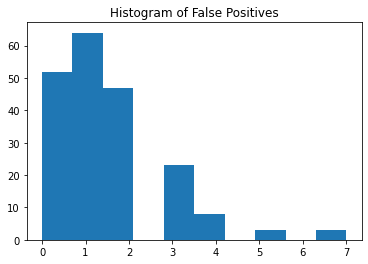

In [5]:
fig1 = plt.hist(fp)
plt.title(r'Histogram of False Positives')

Text(0.5, 1.0, 'Histogram of False Positives after Bootstrap')

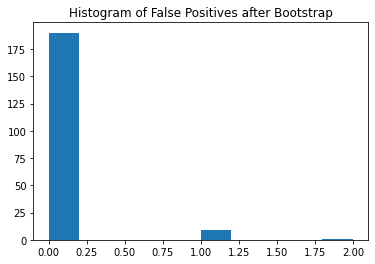

In [6]:
fig2 = plt.hist(mb_fp)
plt.title(r'Histogram of False Positives after Bootstrap')

Under the same model, we implement bootstrap using parallel computing as follows.

In [7]:
from joblib import Parallel, delayed
import multiprocessing
multiprocessing.cpu_count()

6

In [8]:
def boot_sim(m, itcp=True):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = 4 + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    hd_sqr = high_dim(X, Y, intercept=itcp)
    lambda_sim = 0.75*np.quantile(hd_sqr.self_tuning(tau), 0.9)

    boot_model = hd_sqr.boot_inference(Lambda=lambda_sim, tau=tau, \
                                       weight="Multinomial", parallel=True, ncore=3)
    
    mb_ci = boot_model['boot_ci']
    est_set = np.where(boot_model['boot_beta'][itcp:,0]!=0)[0]
    mb_set = boot_model['majority_vote']
    tp =  len(np.intersect1d(true_set, est_set))
    fp  = len(np.setdiff1d(est_set, true_set))
    mb_tp = len(np.intersect1d(true_set, mb_set))
    mb_fp = len(np.setdiff1d(mb_set, true_set))
    
    ci_cover, ci_width = np.zeros([3, p]), np.zeros([3, p])
    for c in range(3):
        ci_cover[c,:] += (beta >= mb_ci[c,itcp:,0])*(beta<= mb_ci[c,itcp:,1])
        ci_width[c,:] += mb_ci[c,itcp:,1] - mb_ci[c,itcp:,0]
        
    return [np.array([tp, fp, mb_tp, mb_fp]), ci_cover, ci_width]

In [9]:
ci_cover, ci_width = np.zeros([3, p]), np.zeros([3, p])
M = 200
# true and false positives
tp, fp = np.zeros(M), np.zeros(M)
mb_tp, mb_fp = np.zeros(M), np.zeros(M)
runtime = 0

for m in range(M):
    rgt.seed(m)
    tic = time.time()
    output = boot_sim(m)
    runtime += time.time() - tic
    tp[m], fp[m], mb_tp[m], mb_fp[m] = output[0][0], output[0][1], output[0][2], output[0][3]
    ci_cover += output[1]
    ci_width += output[2]

In [10]:
cover = pd.DataFrame(np.concatenate([ci_cover.T/M, beta[:,None]], axis=1), columns=['percentile', 'pivotal', 'normal','true beta'])
width = pd.DataFrame(np.concatenate([ci_width.T/M, beta[:,None]], axis=1), columns=['percentile', 'pivotal', 'normal','true beta'])

boot_out = pd.concat([width.iloc[true_set,:3], cover.iloc[true_set,:3]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out,
      '\ntrue model:',      true_set+1,
      '\naverage runtime:', runtime/M,
      '\ntrue positive:',   np.mean(tp), 
      '\nfalse positive:',  np.mean(fp),
      '\nVSC prob:',        np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:',  np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nVSC prob after boot:',  np.mean((mb_tp==8)*(mb_fp==0)))
# VSC: variable selection consistency

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.332476  0.332476  0.338365       0.965    0.885   0.960
3     0.453466  0.453466  0.459352       0.960    0.930   0.970
6     0.347702  0.347702  0.353142       0.950    0.930   0.945
9     0.447805  0.447805  0.457954       0.955    0.960   0.960
12    0.417934  0.417934  0.420568       0.955    0.880   0.925
15    0.309079  0.309079  0.315276       0.975    0.950   0.970
18    0.360613  0.360613  0.367540       0.965    0.920   0.965
21    0.436215  0.436215  0.442141       0.970    0.955   0.980 
true model: [ 1  3  6  9 12 15 18 21] 
average runtime: 3.140219452381134 
true positive: 8.0 
false positive: 1.475 
VSC prob: 0.26 
true pos after boot: 8.0 
false pos after boot: 0.055 
VSC prob after boot: 0.945
